# 12.5 Introduction to generative adversarial networks

Goodfellow等人于2014年推出的生成对抗网络（GAN）, 是VAE学习图像隐空间的替代品。它们通过迫使生成的图像与真实图像几乎无法区分，从而使相当逼真的合成图像的生成成为可能。

理解GAN的一个直观方式是想象一个伪造者试图创作一幅假毕加索画。起初，伪造者在这项任务方面相当糟糕。他把他的一些假货和正宗的毕加索混合在一起，并把它们都给艺术品经销商看。艺术品经销商对每幅画进行真实性评估，并就 是什么让毕加索看起来像毕加索 给出伪造反馈。伪造者回到他的工作室准备一些新的假货。随着时间的推移，伪造者越来越擅长模仿毕加索的风格，艺术品经销商越来越擅长发现假货。最后，他们手上有一些优秀的假毕加索。

这就是GAN：伪造网络和专家网络，各自接受训练，以达到最佳状态。因此，GAN由两部分组成：

- 生成器网络—将随机向量（隐空间中的随机点）作为输入，并将其解码为合成图像。
- 判别器网络（或对手）-将图像（真实或合成）作为输入，并预测图像是来自训练集还是由生成器网络创建。

生成器网络经过训练，能够愚弄判别器网络，因此随着训练的进行，它逐渐生成越来越逼真的图像：看起来与真实图像无法区分的人工图像，以至于判别器网络不可能将两者区分开来（见图12.19）。与此同时，判别器不断适应生成器功能的逐步提高，为生成的图像设定了很高的现实标准。一旦训练结束，生成器将能够将其输入空间中的任何点转换为可信的图像。与VAE不同，这个隐空间对有意义的结构的明确保证较少；特别是，它不是连续的。

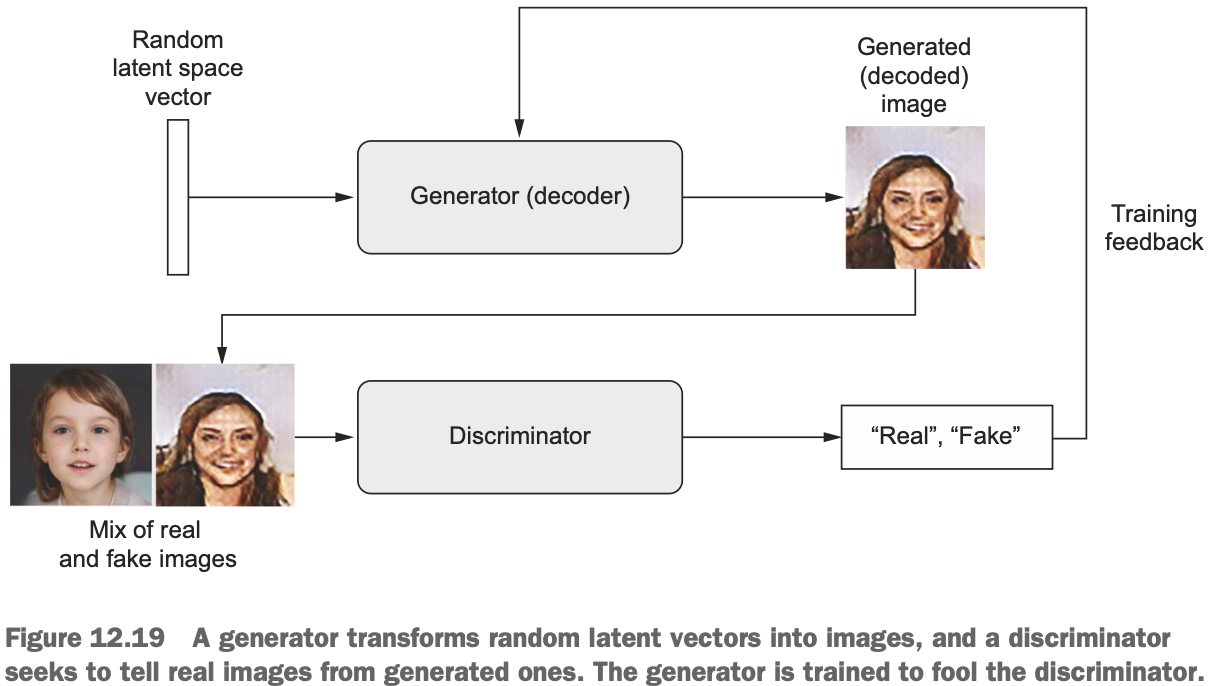

值得注意的是，GAN是一个优化最小值没有固定的系统，这与您在本书中遇到的任何其他训练设置不同。通常，梯度下降包括在 static loss landscape 中下降。 但有了GAN，下山的每一步都会稍微改变整个 landscape。这是一个动态系统，优化过程寻求的不是最小值，而是两种力量之间的平衡。因此，众所周知，GAN很难训练——让GAN工作需要仔细调整模型架构和训练参数。

## 12.5.1 A schematic GAN implementation

在本节中，我们将解释如何在 Keras 中以最短的形式实现GAN。GAN是先进的，因此深入研究像 StyleGAN2 这样的架构的技术细节，生成图12.20中的图像，将超出本书的范围。我们将在本演示中使用的具体实现是深度卷积GAN（DCGAN）：一个非常基本的GAN，其中生成器和判别器是深度convnets。

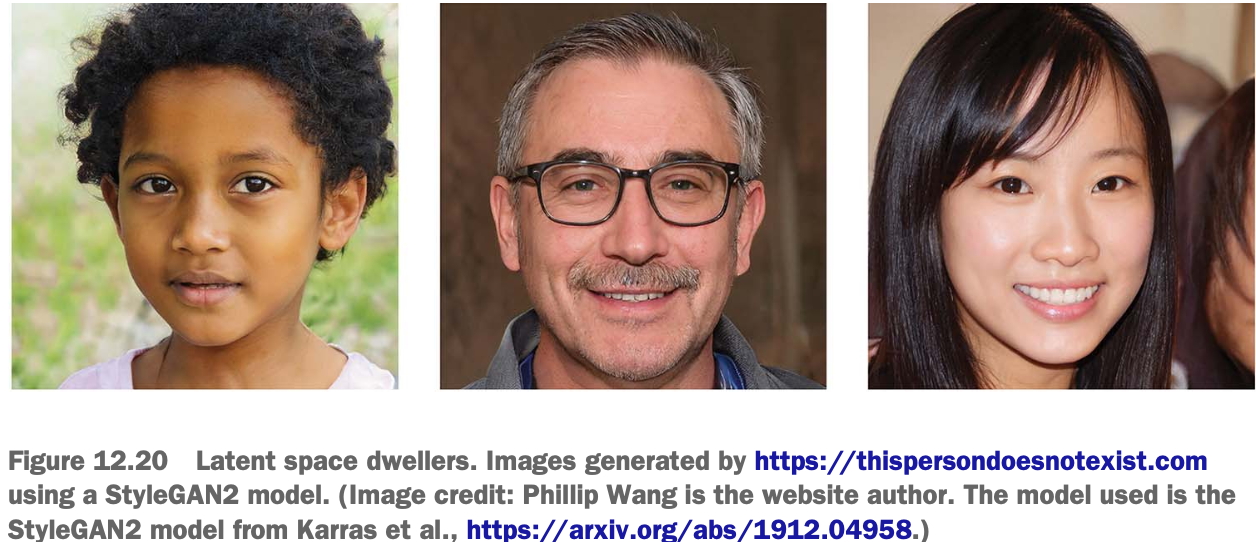

我们将根据来自大型名人面部属性数据集（称为CelebA）的数据集对GAN进行训练，该数据集包含20万张名人面孔（[http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html](ttp://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) ）。为了加快训练，我们将把图像大小调整为64×64，因此我们将学习生成64×64张人脸图像。

从原理上讲，GAN看起来像这样：

- 生成器网络将形状为 `(latent_dim)` 的矢量映射到形状为 `(64、64、3)` 的图像 。
- 判别器网络将形状为 `(64、64、3)` 图像映射到二分类分数，估计图像为真实的概率。
- Gan网络将生成器和判别器链在一起： `gan(x) = discriminator(generator(x))` 。
- 我们使用真实和假图像以及 “真实”/“假” 标签来训练判别器，就像我们训练任何常规图像分类模型一样。
- 为了训练生成器，我们使用gan模型的损失得到对应生成器权重的梯度。这意味着，在每一步，我们都会朝着使判别器更有可能将生成器解码的图像归类为“真实”的方向移动。换句话说，我们训练生成器来愚弄判别器。

## 12.5.2 A bag of tricks

训练GAN 和 调整GAN实现的过程是非常困难的。您应该牢记一些已知的技巧。像深度学习中的大多数事情一样，它更多的是炼金术而不是科学：这些技巧是启发式的，而不是理论支持的指南。它们得到了对手头现象的直观理解的支持，众所周知，它们在经验上都很好，尽管在每种情况下都没有必要。

以下是本节中用于实现GAN生成器和判别器的一些技巧。这不是一份详尽无遗的GAN相关提示列表；您可以在GAN文献中找到更多内容：

- 我们使用步长，而不是池化来对判别器进行下采样特征图，就像我们在VAE编码器中所做的那样。
- 我们使用正态分布（高斯分布）而不是均匀分布从隐空间取样点。
- 随机性有利于诱导鲁棒性。由于GAN训练导致动态平衡，GAN可能会以各种方式卡住。在训练期间引入随机性有助于防止这种情况发生。我们通过在判别器的标签中添加随机噪声来引入随机性。
- 稀疏的梯度会阻碍GAN训练。在深度学习中，稀疏通常是一种理想的属性，但在GAN中并非如此。有两件事可以导致梯度稀疏：最大池化操作和relu激活。我们建议使用步长卷积进行下采样，而不是最大池化，我们建议使用LeakyReLU层而不是relu激活。它类似于relu，但它通过允许小的负激活值来放松稀疏限制。
- 在生成的图像中，经常会看到由生成器中像素空间覆盖率不均导致的棋盘现象见图12.21）。为了解决这个问题，每当我们在生成器和判别器中使用步长Conv2DTranspose或Conv2D时，我们都会使用可被步幅大小整除的卷积核大小。

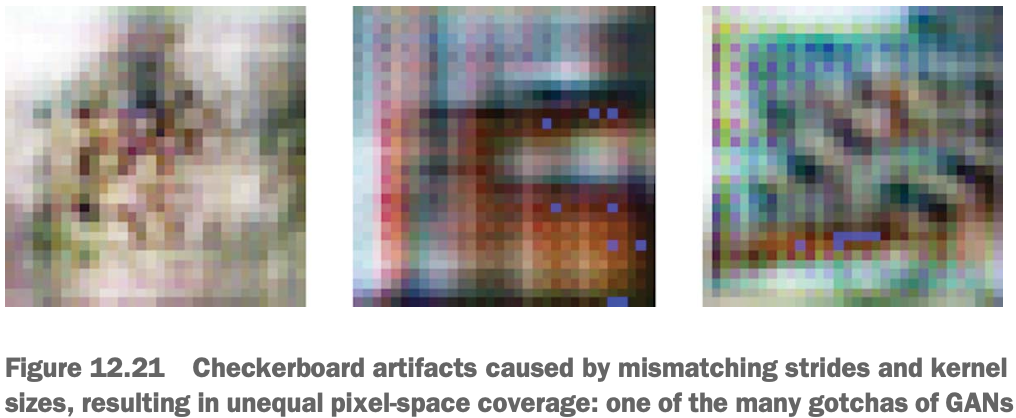

## 12.5.3 Getting our hands on the CelebA dataset

您可以从网站手动下载数据集：[http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 。如果您使用的是Colab，您可以运行以下操作来从Google Drive下载数据并解压缩它。

```
!mkdir celeba_gan
!gdown --id 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 -O celeba_gan/data.zip
!unzip -qq celeba_gan/data.zip -d celeba_gan
```

一旦您在目录中获得了未压缩的图像，您可以使用 `image_dataset_from_directory`  将其转换为数据集。由于我们只需要图像——没有标签——我们将指定 `label_mode=None`。

In [1]:
from tensorflow import keras
dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan",
    label_mode=None,
    image_size=(64, 64),
    batch_size=32,
    smart_resize=True)

Found 202599 files belonging to 1 classes.
Metal device set to: Apple M1


2022-04-20 17:04:13.262404: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-20 17:04:13.262539: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


最后，让我们将图像重新缩放到[0-1]范围。

In [2]:
dataset = dataset.map(lambda x: x / 255.)

您可以使用以下代码来显示示例图像。

2022-04-20 17:04:13.678039: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-20 17:04:13.678162: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


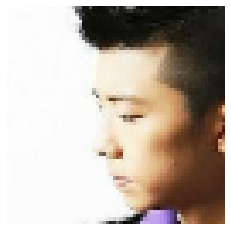

In [3]:
import matplotlib.pyplot as plt 

for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0]) 
    break

## 12.5.4 The discriminator

首先，我们将开发一个判别器模型，该模型将候选图像（真实或合成）作为输入，并将其分为两类之一：“生成图像” 或 “来自训练集的真实图像”。GAN通常出现的许多问题之一是，生成器被生成的看起来像噪音的图像卡住。一个可能的解决方案是在判别器中使用 dropout，所以这就是我们在这里要做的。

In [4]:
from tensorflow.keras import layers
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

In [5]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)            

## 12.5.5 The generator

接下来，让我们开发一个生成器模型，将矢量（从隐空间——在训练期间随机采样）转换为候选图像。

In [6]:
latent_dim = 128
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"), layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"), layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"), layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [7]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 512)       20

## 12.5.6 The adversarial network

最后，我们将设置GAN，将生成器和判别器连接起来。训练后，该模型生成器将向提高其愚弄判别器的能力的方向移动。该模型将隐空间点转换为分类决策——“假”或“真实”——并打算使用始终 “这些是真实图像” 的标签进行训练。因此，训练gan将更新生成器的权重，使判别器在查看假图像时更有可能预测“真实”。

概括地说，这就是训练循环的示意图。对于每个epoch，您执行以下操作：

- 在隐空间中采样随机点（随机噪声）。
- 使用这种随机噪声使用生成器生成图像。
- 将生成的图像与真实图像混合。
- 使用这些混合图像训练判别器，并具有相应的目标：“真实”（真实图像）或“假”（生成图像）。
- 在隐空间中采样新的随机点。
- 使用这些随机向量训练生成器，标签都说 “这些是真实的图像” 这更新了生成器的权重，使它们朝着让判别器预测生成图像的 “这些是真实图像” 的方向移动：这训练生成机愚弄判别器。

让我们来实施它。就像我们的VAE示例一样，我们将使用带有自定义的 `train_step()` 的模型子类。请注意，我们将使用两个优化器（一个用于生成器，一个用于判别器），因此我们还将重写 `compile()`，以允许传递两个优化器。

In [8]:
import tensorflow as tf
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
    
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
    
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        # Adds random noise to the labels—an important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )
        
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        
        misleading_labels = tf.zeros((batch_size, 1))
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))
        
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}
        

在开始训练之前，我们还要设置回调来监控我们的结果：它将在每个 epoch 结束时创建和保存一些生成器生成的假图像。

In [9]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
    
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

最后，我们可以开始训练了。

In [10]:
epochs = 100

gan = GAN(
    discriminator=discriminator, 
    generator=generator, 
    latent_dim=latent_dim)

gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs,
    callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/100


2022-04-20 17:04:14.614397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6332/6332 [==============================] - 9751s 2s/step - d_loss: 0.6189 - g_loss: 1.1569
Epoch 2/100
1251/6332 [====>.........................] - ETA: 2:15:22 - d_loss: 0.6469 - g_loss: 1.0346

KeyboardInterrupt: 

在训练时，您可能会看到对抗性损失开始大幅增加，而判别性损失往往为零——判别器最终可能会主导生成机。如果是这样的话，请尝试降低判别器的学习率，并提高判别器的 dropout 率。


图12.22显示了我们的 GAN 在30个 epoch 的训练后能够产生什么。

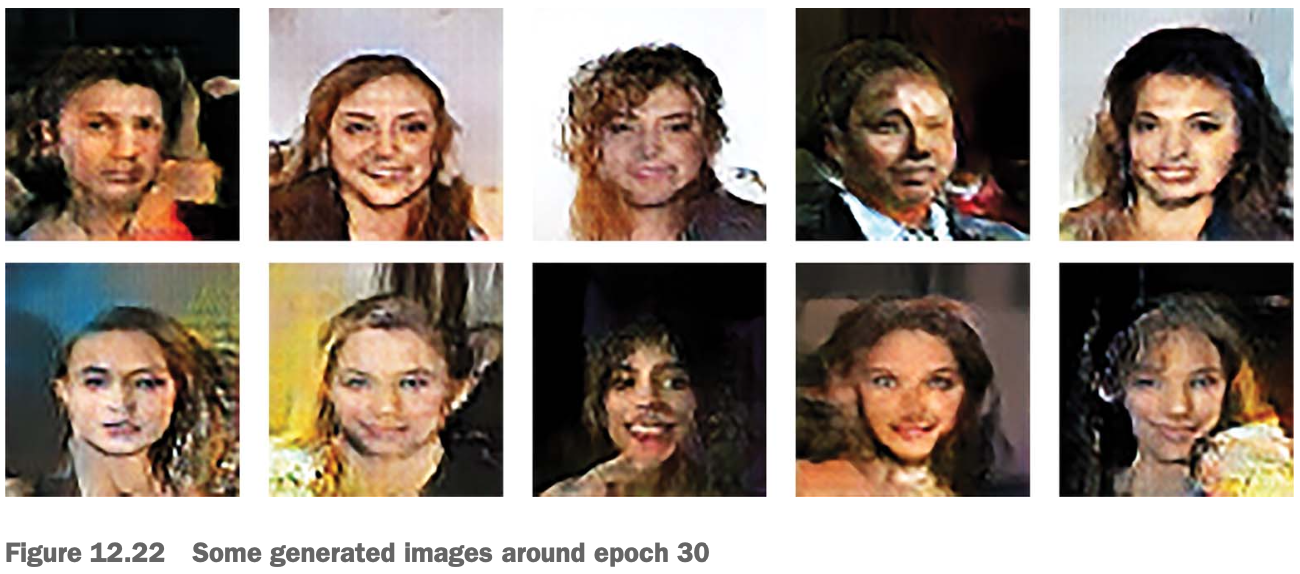

## 12.5.7 Wrapping up

- GAN由生成器网络与判别器网络组成。训练判别器来区分训练数据集中的真实图像和生成器的输出， 生成器训练骗过判别器。 值得注意的是，生成器从未见过训练中的图像直接设置；它所拥有的关于数据的信息来自判别器。
- GAN很难训练，因为训练GAN是一个动态过程，而不是一个具有固定损失 landscape 的简单梯度下降过程。让GAN正确训练需要使用许多启发式技巧，以及广泛的微调。
- GAN可以产生高度逼真的图像。但与VAE不同，他们学习的隐空间没有整洁的连续结构，因此可能不适合某些实际应用，例如通过隐空间概念矢量进行图像编辑。

这几种技术仅涵盖这个快速扩展领域的基础知识。还有很多东西需要发现——生成性深度学习值得拥有一整本书自己的书。

## Summary 

- 您可以使用序列到序列模型来生成序列数据，一步一步。这适用于文本生成，也适用于音符音乐生成或任何其他类型的时间序列数据。
- DeepDream的工作原理是通过输入空间中的梯度上升最大化convnet层激活。
- 在风格迁移算法中，内容图像和风格图像通过梯度下降组合在一起，以生成具有内容图像高级特征和风格图像局部特征的图像。
- VAE和GAN是学习图像隐空间的模型，然后可以通过从隐空间中采样来全新的图像。隐空间中的 `concept vector` 甚至可以用于图像编辑。